In [1]:
import logging.config
import os.path as op

import yaml

from agents.matchmanager import MatchManager
from agents.ml.regressor import RegressorAgent
from agents import GreedyAgent
from core.game.state import vectorStateInfo, vectorState, vectorActionInfo, vectorAction
from core.const import RED, BLUE
from scenarios import scenarioJunction

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pickle

%matplotlib inline

In [2]:
with open(op.join('.', 'logger.config.yaml'), 'r') as stream:
    config = yaml.load(stream, Loader=yaml.FullLoader)
logging.config.dictConfig(config)

In [3]:
def gameJunctionRegressorRegressor(seed:int) -> MatchManager:
    board, state = scenarioJunction()
    playerRed = GreedyAgent(RED, seed)
    playerBlue = GreedyAgent(BLUE, seed)
    mm = MatchManager(' ', playerRed, playerBlue, board, state, seed=seed)
    while not mm.end:
        mm.nextStep()
    
    return mm

In [4]:
seed = 51

In [5]:
MM = gameJunctionRegressorRegressor(seed)

2021-02-15 14:56:22 INFO SCENARIO: Junction
2021-02-15 14:56:22 INFO SEED:     51
2021-02-15 14:56:22 INFO red  : choose positions color darkred
2021-02-15 14:56:23 INFO blue : placed his troops in [ 39 147  99] (7.855555555555553)
2021-02-15 14:56:23 INFO ====================================================================================================
2021-02-15 14:56:23 INFO Turn 0
2021-02-15 14:56:23 INFO red   action   : RED  : rTank3    : Moved to (25, 33) 
2021-02-15 14:56:23 INFO blue  response : BLUE :: Pass 
2021-02-15 14:56:24 INFO blue  action   : BLUE : bInf1     : Attack rTank3 with Anti-tank weapon success=(1 [9]/16) target=(0/1) KILLED!
2021-02-15 14:56:24 INFO red   response : RED  :: Pass 
2021-02-15 14:56:24 INFO red   action   : RED  : rInf3     : Moved to (20, 35) 
2021-02-15 14:56:24 INFO blue  response : BLUE :: Pass 
2021-02-15 14:56:25 INFO blue  action   : BLUE : bInf2     : Attack rInf3 with Mortar success=(1 [17]/17) target=(0/4) KILLED!
2021-02-15 14:56:2

In [13]:
MM.winner

'blue'

In [6]:
df_states = pd.DataFrame(
    columns=vectorStateInfo(),
    data=[vectorState(x) for x in MM.states_history]
)

df_actions = pd.DataFrame(
    columns=vectorActionInfo(),
    data=[vectorAction(x) for x in MM.actions_history]
)
df_red = MM.red.createDataFrame()
df_blue = MM.blue.createDataFrame()

In [7]:
def categoryAction(a):
    return {
        'PassTeam': 0.5,
        'PassFigure': 0.5,
        'Move': 0.75,
        'Attack': 1.0,
        'AttackRespond': 0.25,
        'PassRespond': 0.0,
    }[a]
    
    if a == 'Move':
        return 1.0
    if a == 'Attack':
        return 0.5
    if a == 'Attack':
        return 0.5
    return 0

df_red = df_red.set_index('time')
df_blue = df_blue.set_index('time')

df_red['category_action'] = df_red['action'].apply(categoryAction)
df_blue['category_action'] = df_blue['action'].apply(categoryAction)

In [8]:
dx = pd.concat([
    df_red,
    df_blue
]).sort_index()

In [9]:
dx[['team', 'count', 'action', 'category_action']]

,team,count,action,category_action
time,,,,
2021-02-15 14:56:23.697397,red,1,Move,0.75
2021-02-15 14:56:23.716385,blue,1,PassTeam,0.50
2021-02-15 14:56:24.453381,blue,2,Attack,1.00
2021-02-15 14:56:24.467376,red,2,PassTeam,0.50
2021-02-15 14:56:24.720374,red,3,Move,0.75
2021-02-15 14:56:24.739379,blue,3,PassTeam,0.50
2021-02-15 14:56:25.378382,blue,4,Attack,1.00
2021-02-15 14:56:25.389377,red,4,PassTeam,0.50
2021-02-15 14:56:25.565376,red,5,Move,0.75


In [10]:
{
    'PassFigure': 0.5,
    'Move': 0.75,
    'Attack': 1.0,
    'AttackRespond': 0.25,
    'PassRespond': 0.0,
}

{'PassFigure': 0.5,
 'Move': 0.75,
 'Attack': 1.0,
 'AttackRespond': 0.25,
 'PassRespond': 0.0}

(<AxesSubplot:xlabel='time'>,
 <AxesSubplot:xlabel='time'>,
 <AxesSubplot:xlabel='time'>)

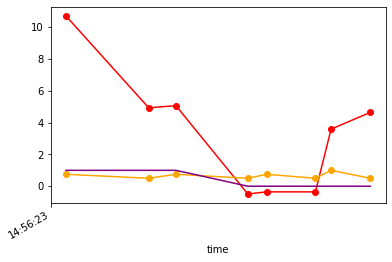

In [11]:
(
    df_red.score.plot(color='red', marker='o'),
    df_red.category_action.plot(color='orange', marker='o'), 
    df_red.entropy.plot(color='purple')
)

(<AxesSubplot:xlabel='time'>,
 <AxesSubplot:xlabel='time'>,
 <AxesSubplot:xlabel='time'>)

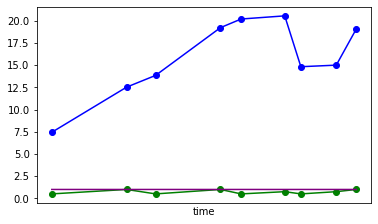

In [12]:
(
    df_blue.score.plot(color='blue', marker='o'),
    df_blue.category_action.plot(color='green', marker='o'), 
    df_blue.entropy.plot(color='purple')
)

(<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>)

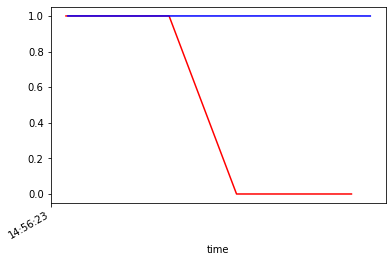

In [14]:
dx[dx['team']=='red']['entropy'].plot(color='red'), dx[dx['team']=='blue']['entropy'].plot(color='blue')